#  Инициализация весов нейронных сетей. Способы регуляризации нейронных сетей. Продвинутые алгоритмы градиентного спуска.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/nn.init.html
* https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
* https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
* https://pytorch.org/docs/stable/optim.html

In [1]:
import torch
import torch.nn as nn


## Задачи для совместного разбора

1\. Инициализируйте веса полносвязного слоя единицами, а смещения - нулями.

In [2]:

linear_layer = nn.Linear(10, 5)
nn.init.constant_(linear_layer.weight, 1.0)


nn.init.constant_(linear_layer.bias, 0.0)

print(linear_layer.weight.data)
print(linear_layer.bias.data)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([0., 0., 0., 0., 0.])


2\. Изучите, как работает слой `nn.Dropout` в режиме обучения модели и в режиме использования модели.

In [7]:
# Создаем модель с Dropout
class ModelWithDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.dropout = nn.Dropout(p=p)
        self.linear = nn.Linear(10, 5)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.dropout(x)
        return x

model = ModelWithDropout(p=0.3)
model.train()

x = torch.ones(3, 10)
output_train = model(x)
print(x[0, :5])
print(output_train[0, :5])


model.eval()
output_eval = model(x)
print(x[0, :5])
print(output_eval[0, :5])

tensor([1., 1., 1., 1., 1.])
tensor([-0.0000, 1.4850, 0.5949, 0.0000, 0.5292], grad_fn=<SelectBackward0>)
tensor([1., 1., 1., 1., 1.])
tensor([-0.0883,  1.0395,  0.4164,  0.0968,  0.3704],
       grad_fn=<SelectBackward0>)


3\. Изучите, как работает слой `nn.BatchNorm1d` в режиме обучения модели и в режиме использования модели.
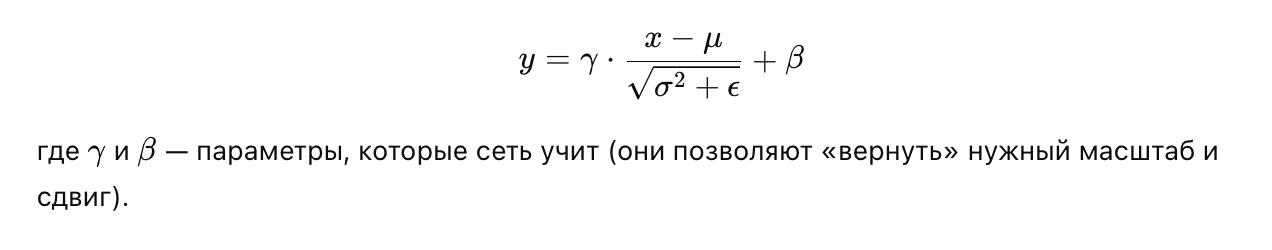

In [13]:
class ModelWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10, 5)
        self.batchnorm = nn.BatchNorm1d(5) #(x - mean) / torch.sqrt(var + eps)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.batchnorm(x)
        return x

model = ModelWithBatchNorm()


model.train()
x = torch.randn(4, 10) * 2 + 1  
output_train = model(x)
print(x[0, :5])
print(output_train[0, :5])



model.eval()
output_eval = model(x)
print(x[0, :5])
print(output_eval[0, :5])



tensor([ 2.3183,  1.3450, -0.9947,  2.1036,  1.5575])
tensor([-0.3390,  1.2501, -0.0550, -0.2362, -0.9408],
       grad_fn=<SelectBackward0>)
tensor([ 2.3183,  1.3450, -0.9947,  2.1036,  1.5575])
tensor([-0.9256,  0.4342,  0.3908, -0.0261, -2.0161],
       grad_fn=<SelectBackward0>)


## Задачи для самостоятельного решения

In [15]:

import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


<p class="task" id="1"></p>

1\. Расширьте класс `torch.nn.Linear`, описав класс `InitializedLinear` и добавив возможность инициализировать веса слоя при помощи функций из пакета `torch.nn.init` (инициализацию bias оставьте по умолчанию). Обратите внимание, что данные функции имеют дополнительные параметры. Данные параметры должны передаваться в момент создания объекта класса `InitializedLinear`.

Пример создания слоя:
```
InitializedLinear(n_features, n_hidden, init_f=nn.init.uniform_, init_args={"a": 0.0, "b": 1.0})
```

- [ ] Проверено на семинаре

In [17]:
import torch
import torch.nn as nn
import torch.nn.init as init

class InitializedLinear(nn.Linear):
    def __init__(self, in_features, out_features, init_f=nn.init.uniform_, init_args=None, bias=True):
        super().__init__(in_features, out_features, bias=bias)
        
        if init_args is None:
            init_args = {}
        
        init_f(self.weight, **init_args)
        if self.bias is not None:
            init.constant_(self.bias, 0.0)
    
    def extra_repr(self):
        """Дополнительная информация для print()"""
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'


<p class="task" id="2"></p>

2\. Решите задачу регрессии несколько раз, изменяя способ инициализации весов. Рассмотрите следующие варианты:
* `nn.init.uniform_` - равномерное распределение 
* `nn.init.normal_` - нормальное распределение 
* `nn.init.constant_` - постоянные значения 
* `nn.xavier_uniform_` - math.sqrt(6.0 / (fan_in + fan_out)), Веса масштабируются в зависимости от размеров слоя. Когда использовать: Для слоев с tanh или sigmoid активациями.
* `nn.kaiming_uniform_` - Когда использовать: Для слоев с ReLU активациями (самый популярный случай!) var = 2/xij (тоже нормальное распределение как и ксавье) std = √(2 / fan_in)

Визуализируйте график изменения значений MSE с ходом эпох. Дайте кривым, соответствующие разным способам инициализации, различные цвета и добавьте подписи. Для улучшения читаемости графиков можно рассматривать области экстремальных значений отдельно.

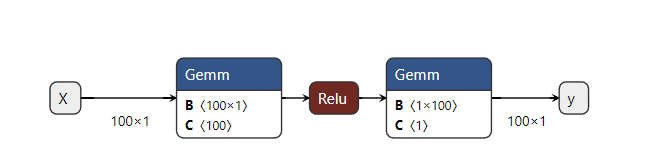

- [ ] Проверено на семинаре

Обучение с uniform
 MSE: train=0.144323, test=0.126172
Обучение с normal
 MSE: train=0.169790, test=0.149397
Обучение с constant
 MSE: train=0.513249, test=0.424795
Обучение с xavier_uniform
 MSE: train=0.171082, test=0.150404
Обучение с kaiming_uniform
 MSE: train=0.156770, test=0.137551


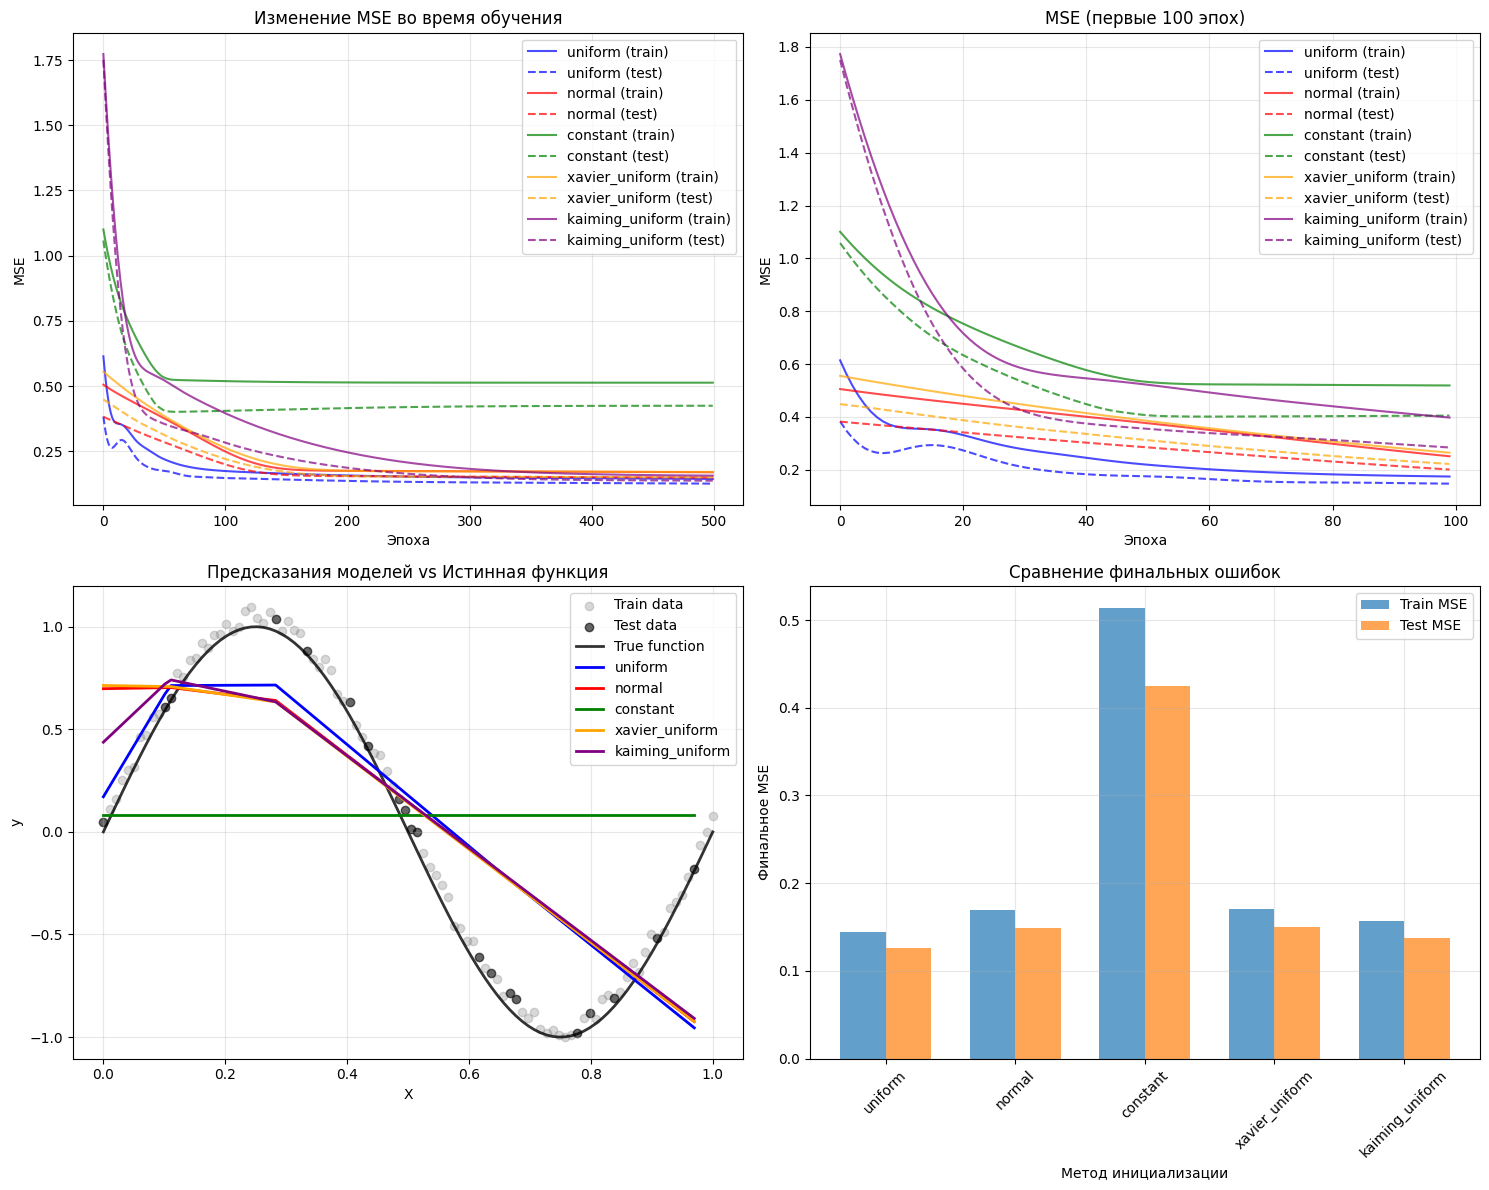

In [54]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())

test_size=0.2
n_samples = X.shape[0]
n_test = int(n_samples * test_size)
indices = torch.randperm(n_samples)
test_idx, train_idx = indices[:n_test], indices[n_test:]

X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]


class RegressionNet(nn.Module):
    def __init__(self, init_method, init_args=None):
        super().__init__()
        self.fc1 = nn.Linear(1, 100)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 1)  
        
        self.init_weights(init_method, init_args)
    
    def init_weights(self, init_method, init_args):
        if init_args is None:
            init_args = {}
        
        init_method(self.fc1.weight, **init_args)
        init_method(self.fc2.weight, **init_args)
        
        init.constant_(self.fc1.bias, 0.0)
        init.constant_(self.fc2.bias, 0.0)
    
    def forward(self, x):
        x = self.fc1(x)     
        x = self.relu(x)     
        x = self.fc2(x)      
        return x

initialization_methods = {
    'uniform': (init.uniform_, {'a': -1.0, 'b': 1.0}),
    'normal': (init.normal_, {'mean': 0.0, 'std': 0.1}),
    'constant': (init.constant_, {'val': 0.1}),
    'xavier_uniform': (init.xavier_uniform_, {}),
    'kaiming_uniform': (init.kaiming_uniform_, {})
}

colors = ['blue', 'red', 'green', 'orange', 'purple']

def train_model(init_name, init_func, init_args, n_epochs=1000):
    model = RegressionNet(init_func, init_args)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = criterion(y_test_pred, y_test)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
    
    return train_losses, test_losses, model

def plot_results_comprehensive(results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # График 1: Общий вид MSE
    ax1 = axes[0, 0]
    for (init_name, (train_losses, test_losses, _)), color in zip(results.items(), colors):
        ax1.plot(train_losses, color=color, linestyle='-', alpha=0.7, label=f'{init_name} (train)')
        ax1.plot(test_losses, color=color, linestyle='--', alpha=0.7, label=f'{init_name} (test)')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('MSE')
    ax1.set_title('Изменение MSE во время обучения')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Увеличенный вид (первые 100 эпох)
    ax2 = axes[0, 1]
    for (init_name, (train_losses, test_losses, _)), color in zip(results.items(), colors):
        ax2.plot(train_losses[:100], color=color, linestyle='-', alpha=0.7, label=f'{init_name} (train)')
        ax2.plot(test_losses[:100], color=color, linestyle='--', alpha=0.7, label=f'{init_name} (test)')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('MSE')
    ax2.set_title('MSE (первые 100 эпох)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: Финальные предсказания
    ax3 = axes[1, 0]
    # Сортируем для красивого графика
    sorted_indices = torch.argsort(X_test.squeeze())
    X_test_sorted = X_test[sorted_indices]
    y_test_sorted = y_test[sorted_indices]
    
    ax3.scatter(X_train.numpy(), y_train.numpy(), alpha=0.3, label='Train data', color='gray')
    ax3.scatter(X_test_sorted.numpy(), y_test_sorted.numpy(), alpha=0.6, label='Test data', color='black')
    
    # Истинная функция
    x_true = torch.linspace(0, 1, 100).view(-1, 1)
    y_true = torch.sin(2 * torch.pi * x_true)
    ax3.plot(x_true.numpy(), y_true.numpy(), 'k-', label='True function', linewidth=2, alpha=0.8)
    
    for (init_name, (_, _, model)), color in zip(results.items(), colors):
        with torch.no_grad():
            y_pred_sorted = model(X_test_sorted)
        ax3.plot(X_test_sorted.numpy(), y_pred_sorted.numpy(), color=color, label=init_name, linewidth=2)
    
    ax3.set_xlabel('X')
    ax3.set_ylabel('y')
    ax3.set_title('Предсказания моделей vs Истинная функция')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # График 4: Финальные значения MSE
    ax4 = axes[1, 1]
    final_train_mse = [train_losses[-1] for train_losses, _, _ in results.values()]
    final_test_mse = [test_losses[-1] for _, test_losses, _ in results.values()]
    
    x_pos = np.arange(len(results))
    width = 0.35
    
    ax4.bar(x_pos - width/2, final_train_mse, width, label='Train MSE', alpha=0.7)
    ax4.bar(x_pos + width/2, final_test_mse, width, label='Test MSE', alpha=0.7)
    
    ax4.set_xlabel('Метод инициализации')
    ax4.set_ylabel('Финальное MSE')
    ax4.set_title('Сравнение финальных ошибок')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(results.keys(), rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



results = {}

for init_name, (init_func, init_args) in initialization_methods.items():
    print(f"Обучение с {init_name}")
    train_losses, test_losses, model = train_model(init_name, init_func, init_args, n_epochs=500)
    results[init_name] = (train_losses, test_losses, model)
    print(f" MSE: train={train_losses[-1]:.6f}, test={test_losses[-1]:.6f}")


plot_results_comprehensive(results)



<p class="task" id="3"></p>

3\. Исследуйте, как добавление дропаута влияет на процесс обучения модели. Решите задачу регрессии несколько раз, изменяя значения вероятности дропаута $p$ от 0 до 0.8. В качестве модели рассмотрите нейронную сеть с одним скрытым слоем.

Визуализируйте график изменения значений $R^2$ в зависимости от вероятности дропаута $p$ на обучающей и тестовой выборке. Визуализируйте на отдельном графике зависимости разности между $R^2$ на обучающей выборки и $R^2$ на тестовой выборке.

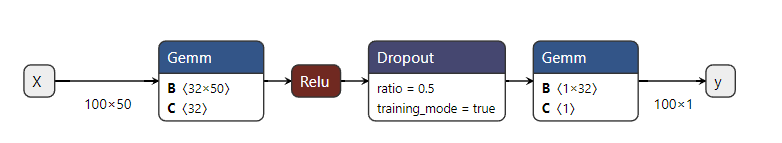

- [ ] Проверено на семинаре

=== Исследование влияния Dropout ===
Архитектура: Input(50) → Linear(50, 32) → ReLU → Dropout → Linear(32, 1) → Output
Размер обучающей выборки: torch.Size([70, 50])
Размер тестовой выборки: torch.Size([30, 50])

Обучение с dropout p = 0.0
  R²: train=0.5288, test=0.0603
Обучение с dropout p = 0.1
  R²: train=0.5115, test=0.0619
Обучение с dropout p = 0.2
  R²: train=0.5016, test=0.0668
Обучение с dropout p = 0.3
  R²: train=0.4821, test=0.0390
Обучение с dropout p = 0.4
  R²: train=0.4560, test=0.0539
Обучение с dropout p = 0.5
  R²: train=0.4312, test=0.0510
Обучение с dropout p = 0.6
  R²: train=0.4057, test=0.0775
Обучение с dropout p = 0.7
  R²: train=0.3503, test=0.0574
Обучение с dropout p = 0.8
  R²: train=0.2787, test=0.0455


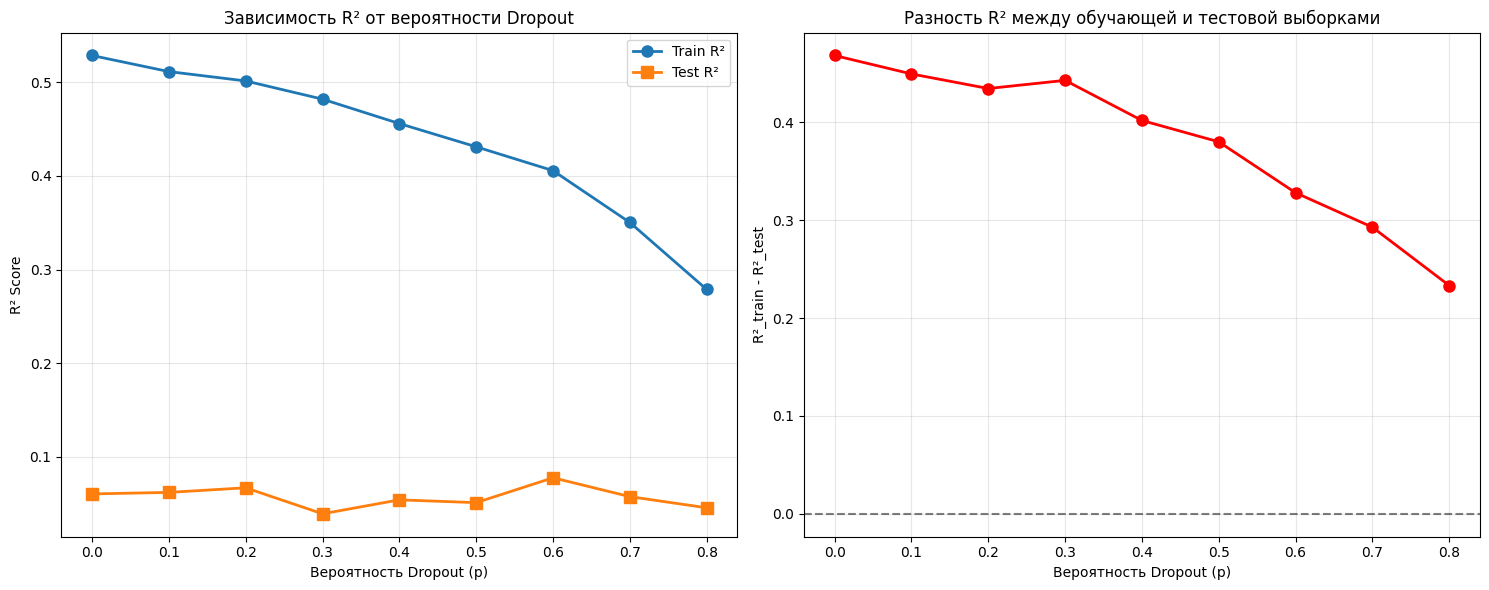

In [62]:
from sklearn.datasets import make_regression
import torch as th
from sklearn.metrics import r2_score

th.manual_seed(42)
X, y, coef = make_regression(
    n_samples=100, 
    n_features=50, 
    n_informative=20, 
    noise=2,
    coef=True,  
    random_state=42,
    
)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)


test_size=0.3
n_samples = X.shape[0]
n_test = int(n_samples * test_size)
indices = torch.randperm(n_samples)
test_idx, train_idx = indices[:n_test], indices[n_test:]

X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

class RegressionNetWithDropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(50, 32) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(32, 1)   
        
        self.init_weights()
    
    def init_weights(self):
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        init.constant_(self.fc1.bias, 0.0)
        init.constant_(self.fc2.bias, 0.0)
    
    def forward(self, x):
        x = self.fc1(x)      # (batch, 50) → (batch, 32)
        x = self.relu(x)     # ReLU активация
        x = self.dropout(x)  # Dropout (работает только в train mode)
        x = self.fc2(x)      # (batch, 32) → (batch, 1)
        return x

def calculate_r2(model, X, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        # R² = 1 - (SS_residual / SS_total)
        ss_residual = torch.sum((y - y_pred) ** 2)
        ss_total = torch.sum((y - torch.mean(y)) ** 2)
        r2 = 1 - (ss_residual / ss_total)
    return r2.item()

def train_model_with_dropout(dropout_p, n_epochs=1000):
    model = RegressionNetWithDropout(dropout_p=dropout_p)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    train_r2_scores = []
    test_r2_scores = []
    
    for epoch in range(n_epochs):
        # Режим обучения
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        y_pred_train = model(X_train)
        train_loss = criterion(y_pred_train, y_train)
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Оценка на обучающей и тестовой выборках
        train_r2 = calculate_r2(model, X_train, y_train)
        test_r2 = calculate_r2(model, X_test, y_test)
        
        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
    
    return train_r2_scores, test_r2_scores, model

def plot_dropout_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # График 1: R² на обучающей и тестовой выборках
    dropout_probs = list(results.keys())
    
    final_train_r2 = [train_scores[-1] for train_scores, _, _ in results.values()]
    final_test_r2 = [test_scores[-1] for _, test_scores, _ in results.values()]
    
    ax1.plot(dropout_probs, final_train_r2, 'o-', linewidth=2, markersize=8, label='Train R²')
    ax1.plot(dropout_probs, final_test_r2, 's-', linewidth=2, markersize=8, label='Test R²')
    ax1.set_xlabel('Вероятность Dropout (p)')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Зависимость R² от вероятности Dropout')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Разность R² (train - test)
    r2_diff = [train - test for train, test in zip(final_train_r2, final_test_r2)]
    ax2.plot(dropout_probs, r2_diff, 'o-', linewidth=2, markersize=8, color='red')
    ax2.set_xlabel('Вероятность Dropout (p)')
    ax2.set_ylabel('R²_train - R²_test')
    ax2.set_title('Разность R² между обучающей и тестовой выборками')
    ax2.grid(True, alpha=0.3)
    
    # Добавляем горизонтальную линию на нуле
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


# Основной код выполнения
print("=== Исследование влияния Dropout ===")
print("Архитектура: Input(50) → Linear(50, 32) → ReLU → Dropout → Linear(32, 1) → Output")
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print()

# Вероятности dropout для исследования
dropout_probabilities = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results = {}

# Обучаем модели с разными вероятностями dropout
for p in dropout_probabilities:
    print(f"Обучение с dropout p = {p}")
    train_r2, test_r2, model = train_model_with_dropout(dropout_p=p, n_epochs=500)
    results[p] = (train_r2, test_r2, model)
    print(f"  R²: train={train_r2[-1]:.4f}, test={test_r2[-1]:.4f}")

plot_dropout_results(results)



<p class="task" id="4"></p>

4\. Решите задачу регрессии с- и без использования пакетной нормализации. Покажите, как меняется результат обучения моделей при различных значениях скорости обучения (0.001, 0.01, 0.1) за одно и то же количество эпох. 

Визуализируйте график изменения значений $R^2$ в зависимости от эпохи при различных значениях скорости обучения с- и без использования пакетной нормализации.

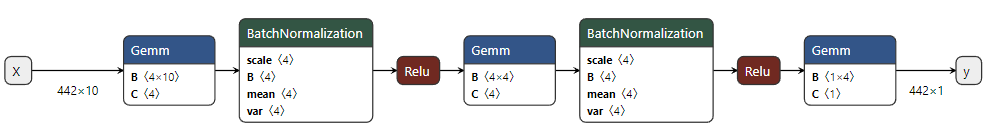

- [ ] Проверено на семинаре

=== Обучение с BatchNorm ===
Learning rate = 0.001...
  Final R²: 0.4723
Learning rate = 0.01...
  Final R²: 0.0405
Learning rate = 0.1...
  Final R²: -3.3625

=== Обучение без BatchNorm ===
Learning rate = 0.001...
  Final R²: 0.4019
Learning rate = 0.01...
  Final R²: 0.5112
Learning rate = 0.1...
  Final R²: 0.5038


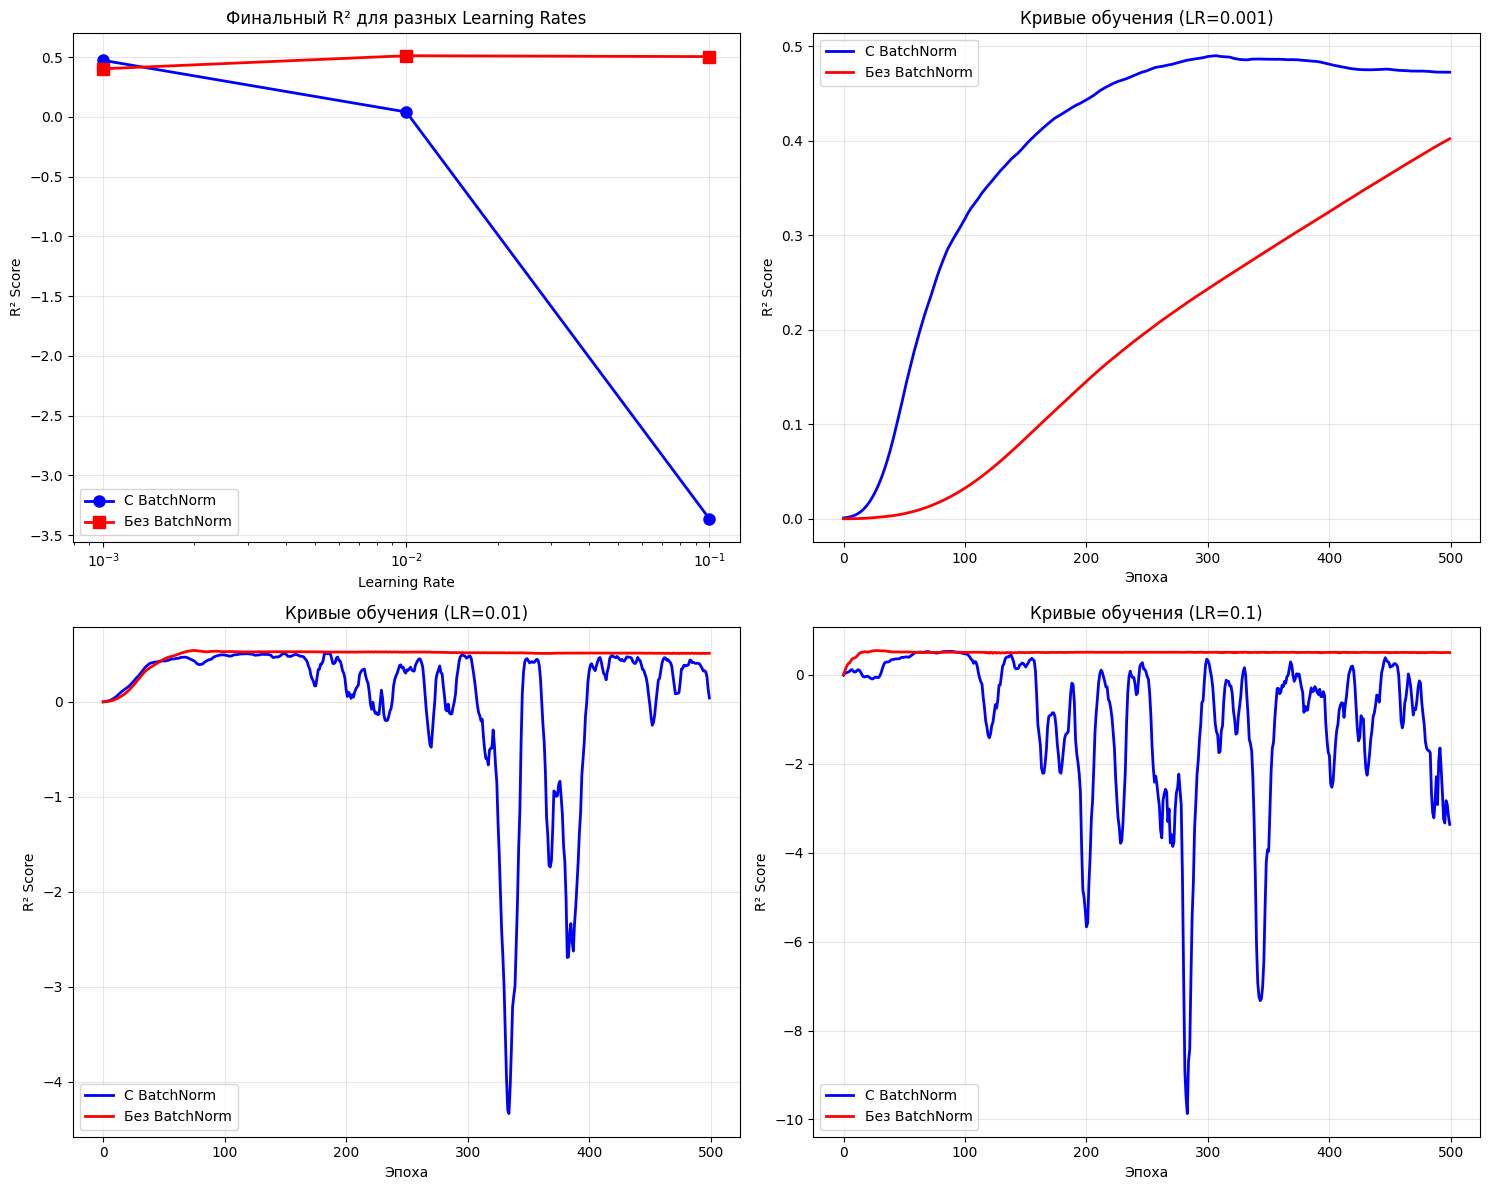

In [ ]:
from sklearn.datasets import load_diabetes
seed = 110
torch.manual_seed(seed)  # PyTorch
import random
random.seed(seed)        # Python
import numpy as np
np.random.seed(seed)

X, y = load_diabetes(return_X_y=True)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)
y = (y - y.mean())/y.std()


n_samples = X.shape[0]
n_test = int(n_samples * test_size)
indices = torch.randperm(n_samples)
test_idx, train_idx = indices[:n_test], indices[n_test:]

X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]


class RegressionNetWithBN(nn.Module):
    def __init__(self, use_batchnorm=True):
        super().__init__()
        self.use_batchnorm = use_batchnorm
        
        self.fc1 = nn.Linear(10, 4)      

        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm1d(4)  
        
        self.fc2 = nn.Linear(4, 4)        

        if self.use_batchnorm:
            self.bn2 = nn.BatchNorm1d(4)   #momentum=0.1, eps=1e-4

        self.fc3 = nn.Linear(4, 1) 
        
        self.init_weights()
    
    def init_weights(self):
        # Для слоев ПЕРЕД BatchNorm - Kaiming
        init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        #init.xavier_uniform_(self.fc1.weight)
        #init.xavier_uniform_(self.fc2.weight)
        #init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        # Для выходного слоя - маленькие веса чтобы компенсировать ReLU
        init.normal_(self.fc3.weight, mean=0.0, std=0.01)
        #init.xavier_uniform_(self.fc3.weight)
        
        init.constant_(self.fc1.bias, 0.0)
        init.constant_(self.fc2.bias, 0.0)
        init.constant_(self.fc3.bias, 0.0)
    
    def forward(self, x):
        
        
        x = self.fc1(x)         
        if self.use_batchnorm:
            x = self.bn1(x)      
            
        x = torch.relu(x)       

        x = self.fc2(x)          
        
        if self.use_batchnorm:
            x = self.bn2(x)      
        
        #x = torch.relu(x)      # Он не может восстановить исходную информацию об отрицательных значениях!
        x = self.fc3(x)         
        return x


def calculate_r2(model, X, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        ss_residual = torch.sum((y - y_pred) ** 2)
        ss_total = torch.sum((y - torch.mean(y)) ** 2)
        r2 = 1 - (ss_residual / ss_total)
    return r2.item()

def train_model(model, learning_rate, n_epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    r2_scores = []
    losses = []
    
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
        # Оценка на тестовой выборке
        r2 = calculate_r2(model, X_test, y_test)
        
        r2_scores.append(r2)
        losses.append(loss.item())
    
    return r2_scores, losses, model

def plot_comparison_results(results_with_bn, results_without_bn):
    learning_rates = list(results_with_bn.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # График 1: Финальные R² для разных learning rates
    ax1 = axes[0, 0]
    final_r2_with_bn = [r2_scores[-1] for r2_scores, _, _ in results_with_bn.values()]
    final_r2_without_bn = [r2_scores[-1] for r2_scores, _, _ in results_without_bn.values()]
    
    ax1.plot(learning_rates, final_r2_with_bn, 'o-', linewidth=2, markersize=8, 
             label='С BatchNorm', color='blue')
    ax1.plot(learning_rates, final_r2_without_bn, 's-', linewidth=2, markersize=8, 
             label='Без BatchNorm', color='red')
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('R² Score')
    ax1.set_title('Финальный R² для разных Learning Rates')
    ax1.set_xscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Кривые обучения для LR=0.001
    ax2 = axes[0, 1]
    lr_key = 0.001
    epochs = range(len(results_with_bn[lr_key][0]))
    
    ax2.plot(epochs, results_with_bn[lr_key][0], label='С BatchNorm', linewidth=2, color='blue')
    ax2.plot(epochs, results_without_bn[lr_key][0], label='Без BatchNorm', linewidth=2, color='red')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('R² Score')
    ax2.set_title(f'Кривые обучения (LR={lr_key})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: Кривые обучения для LR=0.01
    ax3 = axes[1, 0]
    lr_key = 0.01
    
    ax3.plot(epochs, results_with_bn[lr_key][0], label='С BatchNorm', linewidth=2, color='blue')
    ax3.plot(epochs, results_without_bn[lr_key][0], label='Без BatchNorm', linewidth=2, color='red')
    ax3.set_xlabel('Эпоха')
    ax3.set_ylabel('R² Score')
    ax3.set_title(f'Кривые обучения (LR={lr_key})')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # График 4: Кривые обучения для LR=0.1
    ax4 = axes[1, 1]
    lr_key = 0.1
    
    ax4.plot(epochs, results_with_bn[lr_key][0], label='С BatchNorm', linewidth=2, color='blue')
    ax4.plot(epochs, results_without_bn[lr_key][0], label='Без BatchNorm', linewidth=2, color='red')
    ax4.set_xlabel('Эпоха')
    ax4.set_ylabel('R² Score')
    ax4.set_title(f'Кривые обучения (LR={lr_key})')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


learning_rates = [0.001, 0.01, 0.1]
results_with_bn = {}
results_without_bn = {}

print("=== Обучение с BatchNorm ===")
for lr in learning_rates:
    print(f"Learning rate = {lr}...")
    model = RegressionNetWithBN(use_batchnorm=True)
    r2_scores, losses, model = train_model(model, lr, n_epochs=500)
    results_with_bn[lr] = (r2_scores, losses, model)
    print(f"  Final R²: {r2_scores[-1]:.4f}")

print("\n=== Обучение без BatchNorm ===")
for lr in learning_rates:
    print(f"Learning rate = {lr}...")
    model = RegressionNetWithBN(use_batchnorm=False)
    r2_scores, losses, model = train_model(model, lr, n_epochs=500)
    results_without_bn[lr] = (r2_scores, losses, model)
    print(f"  Final R²: {r2_scores[-1]:.4f}")


plot_comparison_results(results_with_bn, results_without_bn)


<p class="task" id="5"></p>

5\. Решите задачу регрессии c использованием различных алгоритмов градиентного спуска. Покажите, как меняется результат обучения моделей при использовании различных алгоритмов (Adam, Adagram, RMSProp, SGD) за одно и то же количество эпох с одной и той же скоростью обучения. Используйте модель с архитектурой, аналогичной модели из предыдущей задачи.

Визуализируйте график изменения значений MAPE в зависимости от эпохи при использовании различных алгоритмов градиентного спуска.

- [ ] Проверено на семинаре

In [107]:
def load_boston():
    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    return data, target

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xr/2b71grmx5nsglymf7xzjs9jr0000gn/T/ipykernel_79704/3520487584.py:6: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [109]:
X, y = load_boston()
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

Обучение с Adam...
  Final MAPE: train=54.03%, test=128.80%
Обучение с Adagrad...
  Final MAPE: train=174.68%, test=122.45%
Обучение с RMSprop...
  Final MAPE: train=55.12%, test=222.34%
Обучение с SGD...
  Final MAPE: train=219.09%, test=166.74%


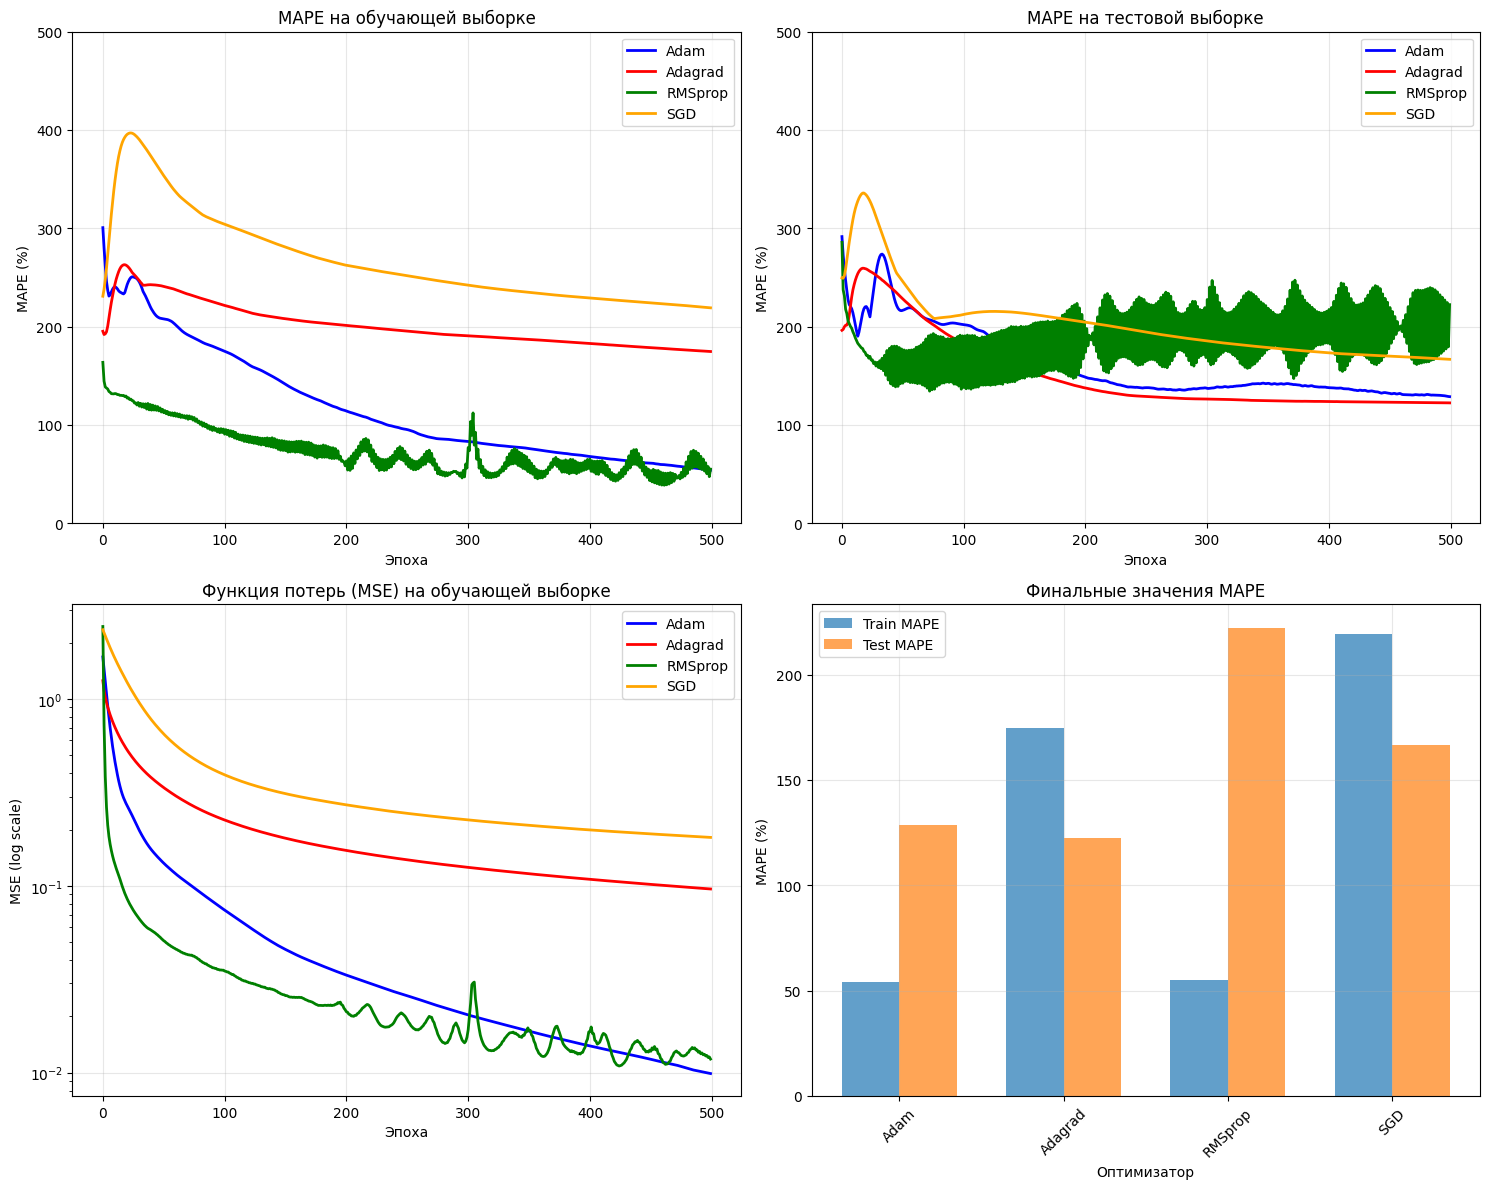

In [162]:
#X = (X - X.mean(dim=0)) / X.std(dim=0)
#y = (y - y.mean()) / y.std()
def set_seed(seed=2):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(25)

n_samples = X.shape[0]
n_test = int(n_samples * test_size)
indices = torch.randperm(n_samples)
test_idx, train_idx = indices[:n_test], indices[n_test:]

X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]


class RegressionNet(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, output_size=1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        
        self.init_weights()
    
    def init_weights(self):
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        init.xavier_uniform_(self.fc3.weight)
        init.constant_(self.fc1.bias, 0.0)
        init.constant_(self.fc2.bias, 0.0)
        init.constant_(self.fc3.bias, 0.0)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

def calculate_mape(model, X, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        # MAPE = mean(|(y_true - y_pred) / y_true|) * 100%
        mape = torch.mean(torch.abs((y - y_pred) / (y + 1e-8))) * 100
    return mape.item()

def train_model_with_optimizer(optimizer_name, learning_rate=0.0001, n_epochs=1000):
    model = RegressionNet(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")
    
    train_mape_scores = []
    test_mape_scores = []
    train_losses = []
    
    for epoch in range(n_epochs):
        # Режим обучения
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        y_pred_train = model(X_train)
        train_loss = criterion(y_pred_train, y_train)
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        train_mape = calculate_mape(model, X_train, y_train)
        test_mape = calculate_mape(model, X_test, y_test)
        
        train_mape_scores.append(train_mape)
        test_mape_scores.append(test_mape)
        train_losses.append(train_loss.item())
    
    return train_mape_scores, test_mape_scores, train_losses, model

def plot_optimizer_comparison(results):
    optimizers = list(results.keys())
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # График 1: MAPE на обучающей выборке
    for idx, (optimizer, (train_mape, test_mape, train_loss, _)) in enumerate(results.items()):
        epochs = range(len(train_mape))
        ax1.plot(epochs, train_mape, color=colors[idx], linewidth=2, label=optimizer)
    
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('MAPE (%)')
    ax1.set_title('MAPE на обучающей выборке')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 500)  # MAPE в процентах
    
    # График 2: MAPE на тестовой выборке
    for idx, (optimizer, (train_mape, test_mape, train_loss, _)) in enumerate(results.items()):
        epochs = range(len(test_mape))
        ax2.plot(epochs, test_mape, color=colors[idx], linewidth=2, label=optimizer)
    
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('MAPE (%)')
    ax2.set_title('MAPE на тестовой выборке')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 500)
    
    # График 3: Loss (MSE) на обучающей выборке
    for idx, (optimizer, (train_mape, test_mape, train_loss, _)) in enumerate(results.items()):
        epochs = range(len(train_loss))
        ax3.semilogy(epochs, train_loss, color=colors[idx], linewidth=2, label=optimizer)
    
    ax3.set_xlabel('Эпоха')
    ax3.set_ylabel('MSE (log scale)')
    ax3.set_title('Функция потерь (MSE) на обучающей выборке')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # График 4: Финальные значения MAPE
    ax4 = plt.subplot(2, 2, 4)
    final_train_mape = [train_mape[-1] for train_mape, _, _, _ in results.values()]
    final_test_mape = [test_mape[-1] for _, test_mape, _, _ in results.values()]
    
    x_pos = np.arange(len(optimizers))
    width = 0.35
    
    ax4.bar(x_pos - width/2, final_train_mape, width, label='Train MAPE', alpha=0.7)
    ax4.bar(x_pos + width/2, final_test_mape, width, label='Test MAPE', alpha=0.7)
    
    ax4.set_xlabel('Оптимизатор')
    ax4.set_ylabel('MAPE (%)')
    ax4.set_title('Финальные значения MAPE')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(optimizers, rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



optimizers = ['Adam', 'Adagrad', 'RMSprop', 'SGD']
results = {}


for optimizer_name in optimizers:
    print(f"Обучение с {optimizer_name}...")
    train_mape, test_mape, train_loss, model = train_model_with_optimizer(
        optimizer_name=optimizer_name, 
        learning_rate=0.001,
        n_epochs=500
    )
    results[optimizer_name] = (train_mape, test_mape, train_loss, model)
    print(f"  Final MAPE: train={train_mape[-1]:.2f}%, test={test_mape[-1]:.2f}%")


plot_optimizer_comparison(results)





<p class="task" id="6"></p>

6\. Решите задачу регрессии c использованием ранней остановки. Разбейте набор данных на обучающую и валидационную выборку в соотношении 80 на 20. Остановите процесс обучения, если целевая метрика (MAPE) не уменьшалась в течении последних $k$ ($k$ - гиперпараметр метода) эпох. В момент остановки выведите сообщение с текущим номером эпохи.

- [ ] Проверено на семинаре


 Обучение с ранней остановкой...

ES на эпохе 87
   Лучшая val MAPE: 95.13%
   Количество эпох без улучшения: 30
Веса восстановлены до лучшей эпохи (57)
  Final MAPE: train=138.93%, val=95.13%

 Обучение без ранней остановки...
  Final MAPE: train=29.98%, val=135.49%


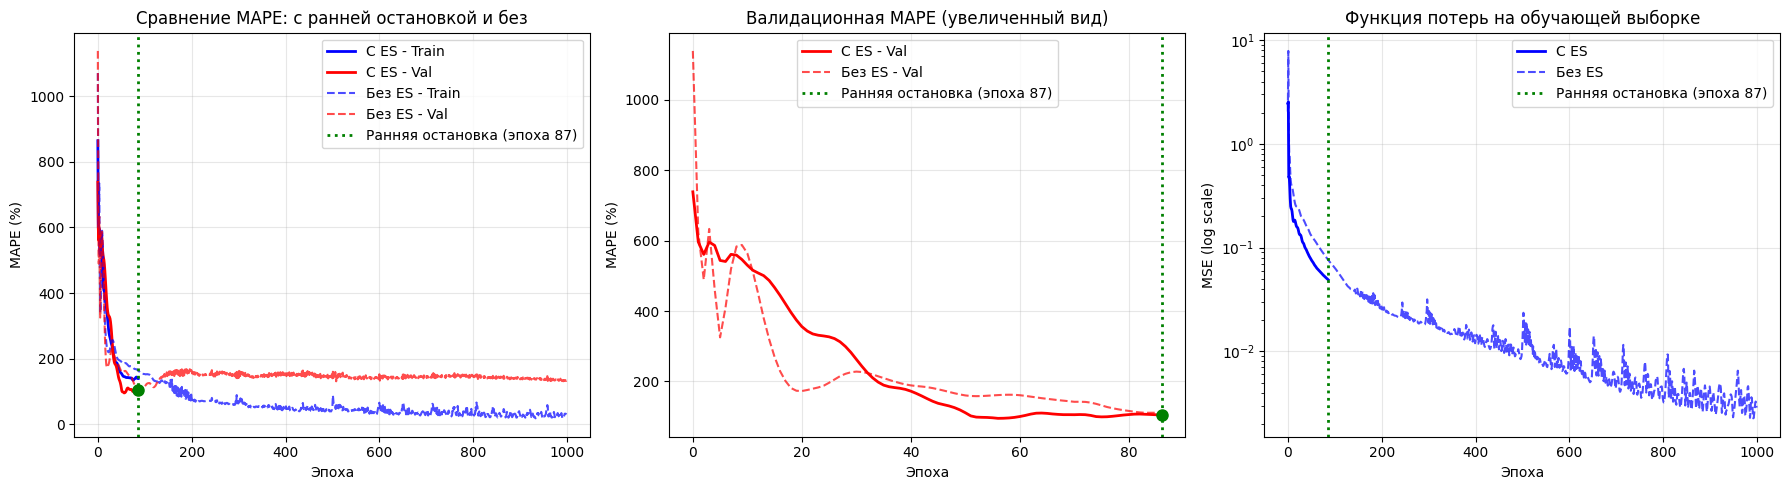

In [230]:
def set_seed(seed=2):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(51)

train_size=0.8  
val_size=0.2
n_samples = X.shape[0]
n_train = int(n_samples * train_size)
n_val = n_samples - n_train  

indices = torch.randperm(n_samples)

train_idx = indices[:n_train]
val_idx = indices[n_train:]
X_train, X_val, y_train, y_val = X[train_idx], X[val_idx], y[train_idx], y[val_idx]


def train_model(use_early_stopping=True, patience=20, max_epochs=1000, learning_rate=0.05):
    model = RegressionNet(input_size=X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Переменные для ранней остановки
    best_val_score = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_weights = None
    
    train_mape_scores = []
    val_mape_scores = []
    train_losses = []
    
    print(f"\n Обучение {'с ранней остановкой' if use_early_stopping else 'без ранней остановки'}...")
    
    for epoch in range(max_epochs):
        # Режим обучения
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        y_pred_train = model(X_train)
        train_loss = criterion(y_pred_train, y_train)
        
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Вычисляем MAPE на обучающей и валидационной выборках
        train_mape = calculate_mape(model, X_train, y_train)
        val_mape = calculate_mape(model, X_val, y_val)
        
        train_mape_scores.append(train_mape)
        val_mape_scores.append(val_mape)
        train_losses.append(train_loss.item())
        
        # Логика ранней остановки
        if use_early_stopping:
            if val_mape < best_val_score:
                best_val_score = val_mape
                best_epoch = epoch + 1
                patience_counter = 0
                # Сохраняем лучшие веса
                best_weights = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'\nES на эпохе {epoch + 1}')
                    print(f'   Лучшая val MAPE: {best_val_score:.2f}%')
                    print(f'   Количество эпох без улучшения: {patience_counter}')
                    
                    # Восстанавливаем лучшие веса
                    if best_weights is not None:
                        model.load_state_dict(best_weights)
                        print(f'Веса восстановлены до лучшей эпохи ({best_epoch})')
                    
                    break
    
    if not use_early_stopping:
        best_epoch = max_epochs
        best_val_score = val_mape_scores[-1] if val_mape_scores else float('inf')
        print(f"  Final MAPE: train={train_mape_scores[-1]:.2f}%, val={val_mape_scores[-1]:.2f}%")
    else:
        print(f"  Final MAPE: train={train_mape_scores[-1]:.2f}%, val={best_val_score:.2f}%")
    
    return train_mape_scores, val_mape_scores, train_losses, model, best_epoch, best_val_score


def plot_comparison(results_with_es, results_without_es):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Извлекаем данные
    (train_mape_es, val_mape_es, train_loss_es, _, best_epoch_es, _) = results_with_es
    (train_mape_no_es, val_mape_no_es, train_loss_no_es, _, best_epoch_no_es, _) = results_without_es
    
    epochs_es = range(len(train_mape_es))
    epochs_no_es = range(len(train_mape_no_es))
    
    # График 1: MAPE сравнение
    ax1.plot(epochs_es, train_mape_es, 'b-', linewidth=2, label='С ES - Train')
    ax1.plot(epochs_es, val_mape_es, 'r-', linewidth=2, label='С ES - Val')
    ax1.plot(epochs_no_es, train_mape_no_es, 'b--', alpha=0.7, label='Без ES - Train')
    ax1.plot(epochs_no_es, val_mape_no_es, 'r--', alpha=0.7, label='Без ES - Val')
    
    # Отмечаем точку ранней остановки
    if len(epochs_es) < len(epochs_no_es):
        ax1.axvline(x=len(epochs_es)-1, color='green', linestyle=':', linewidth=2, 
                    label=f'Ранняя остановка (эпоха {len(epochs_es)})')
        ax1.plot(len(epochs_es)-1, val_mape_es[-1], 'go', markersize=8)
    
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('MAPE (%)')
    ax1.set_title('Сравнение MAPE: с ранней остановкой и без')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Увеличенный вид валидационной MAPE
    ax2.plot(epochs_es, val_mape_es, 'r-', linewidth=2, label='С ES - Val')
    ax2.plot(epochs_no_es[:len(epochs_es)], val_mape_no_es[:len(epochs_es)], 
             'r--', alpha=0.7, label='Без ES - Val')
    
    if len(epochs_es) < len(epochs_no_es):
        ax2.axvline(x=len(epochs_es)-1, color='green', linestyle=':', linewidth=2,
                    label=f'Ранняя остановка (эпоха {len(epochs_es)})')
        ax2.plot(len(epochs_es)-1, val_mape_es[-1], 'go', markersize=8)
    
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('MAPE (%)')
    ax2.set_title('Валидационная MAPE (увеличенный вид)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: Функция потерь
    ax3.semilogy(epochs_es, train_loss_es, 'b-', linewidth=2, label='С ES')
    ax3.semilogy(epochs_no_es, train_loss_no_es, 'b--', alpha=0.7, label='Без ES')
    
    if len(epochs_es) < len(epochs_no_es):
        ax3.axvline(x=len(epochs_es)-1, color='green', linestyle=':', linewidth=2,
                    label=f'Ранняя остановка (эпоха {len(epochs_es)})')
    
    ax3.set_xlabel('Эпоха')
    ax3.set_ylabel('MSE (log scale)')
    ax3.set_title('Функция потерь на обучающей выборке')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return len(epochs_es), len(epochs_no_es)

# Обучаем с ранней остановкой
results_with_es = train_model(use_early_stopping=True, patience=30, max_epochs=1000)

# Обучаем без ранней остановки
results_without_es = train_model(use_early_stopping=False, max_epochs=1000)


epochs_es, epochs_no_es = plot_comparison(results_with_es, results_without_es)


## Обратная связь
- [ ] Хочу получить обратную связь по решению